# TNS Ledger Maker

Access CSV downloads from TNS and produce a DESI ToO ledger.

In [43]:
from astropy.io import ascii
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.table import Table, vstack
from astropy import units as u

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [44]:
mpl.rc('font', size=16)

## Access CTIO-4m-DECAM Data

Grab CSV data downloaded from TNS sent from DESIRT.

The search is specifically from the GAMA15 fields observed by DECam from late March to mid-April 2021.

In [126]:
data = ascii.read('desirt_ztf_tns_20210418.csv')
# data_decam = ascii.read('desirt_tns_20210415.csv')
# data_ztf = ascii.read('ztf_tns_20210415.csv')
# print(data_decam.keys())
# print(data_ztf.keys())
# vstack([data_ztf, data_decam], metadata_conflicts='silent')
# data_decam #= data_decam + data_ztf

In [129]:
data.sort('ID')
data

ID,Name,RA,DEC,Obj. Type,Redshift,Host Name,Host Redshift,Reporting Group/s,Discovery Data Source/s,Classifying Group/s,Associated Group/s,Disc. Internal Name,Disc. Instrument/s,Class. Instrument/s,TNS AT,Public,End Prop. Period,Discovery Mag/Flux,Discovery Filter,Discovery Date (UT),Sender,Remarks,Ext. catalog/s
int64,str11,str12,str12,str6,float64,str25,float64,str43,str43,str17,str43,str12,str83,str24,int64,int64,int64,float64,str7,str23,str18,int64,int64
53825,AT 2020caa,14:19:18.625,+00:03:27.04,--,--,WISEA J141918.52+000327.2,0.097034,"ALeRCE, ATLAS, DESIRT","ZTF, ATLAS, DESIRT",--,ATLAS; DESIRT; ZTF,ZTF20aamibse,"ATLAS1 - ACAM1, CTIO-4m - DECAM, P48 - ZTF-Cam",--,1,1,--,19.7699,r-ZTF,2020-02-07 13:06:36.000,ALeRCE,--,--
54723,AT 2020dig,14:41:11.558,-02:12:35.24,--,--,--,--,"ZTF, AMPEL",ZTF,--,ZTF,ZTF18acvjmvs,P48 - ZTF-Cam,--,1,1,--,18.93,g-ZTF,2020-02-20 12:36:44.064,ZTF_AMPEL_COMPLETE,--,--
60945,AT 2020lng,14:09:40.580,+00:32:22.06,--,--,--,--,"ZTF, ATLAS, GaiaAlerts, Pan-STARRS1","ZTF, ATLAS, GaiaAlerts, Pan-STARRS1",--,ATLAS; GaiaAlerts; Pan-STARRS1; ZTF,ZTF20abbumno,"ATLAS1 - ACAM1, Gaia - Gaia-photometric, P48 - ZTF-Cam, PS1 - GPC1",--,1,1,--,20.8038,g-ZTF,2020-05-23 07:37:37.920,ZTF_CLU_PUBLIC,--,--
61599,SN 2020mjm,14:29:29.330,-00:01:17.76,SN II,0.005134,--,--,"ZTF, Pan-STARRS1, ATLAS, GaiaAlerts, DESIRT","ZTF, Pan-STARRS1, ATLAS, GaiaAlerts, DESIRT",Global SN Project,ATLAS; DESIRT; GaiaAlerts; Pan-STARRS1; ZTF,ZTF20abeohfn,"ATLAS1 - ACAM1, CTIO-4m - DECAM, Gaia - Gaia-photometric, P48 - ZTF-Cam, PS1 - GPC1",FTN - FLOYDS-N,1,1,--,16.4047,g-ZTF,2020-06-12 04:37:29.280,ZTF_CLU_PUBLIC,--,--
72163,SN 2020abku,14:00:51.220,-00:11:08.12,SN IIn,0.081828,2MASX J14005146-0011141,0.081828,"ALeRCE, ZTF, GaiaAlerts, ATLAS, Pan-STARRS1","ZTF, GaiaAlerts, ATLAS, Pan-STARRS1",ZTF,ATLAS; GaiaAlerts; Pan-STARRS1; ZTF,ZTF20acusylb,"ATLAS1 - ACAM1, Gaia - Gaia-photometric, P48 - ZTF-Cam, PS1 - GPC1",P60 - SEDM,1,1,--,17.8899,r-ZTF,2020-12-02 13:07:34.000,ALeRCE,--,--
72651,SN 2020acdl,14:32:12.432,+00:13:25.81,SN Ia,0.035546,WISEA J143212.30+001323.2,0.035546,"ALeRCE, ZTF, ATLAS, Pan-STARRS1, DESIRT","ZTF, ATLAS, Pan-STARRS1, DESIRT",ZTF,ATLAS; DESIRT; Pan-STARRS1; ZTF,ZTF20acwfcfs,"ATLAS1 - ACAM1, CTIO-4m - DECAM, P48 - ZTF-Cam, PS1 - GPC1",P60 - SEDM,1,1,--,18.1898,r-ZTF,2020-12-09 13:20:18.001,ALeRCE,--,--
72695,AT 2020acfd,14:50:29.845,-03:28:47.44,--,--,WISEA J145029.77-032845.4,0.0426,"ALeRCE, DESIRT, Pan-STARRS1","ZTF, DESIRT, Pan-STARRS1",--,DESIRT; Pan-STARRS1; ZTF,ZTF20acwqriu,"CTIO-4m - DECAM, P48 - ZTF-Cam, PS1 - GPC1",--,1,1,--,19.4887,r-ZTF,2020-12-10 13:15:10.002,ALeRCE,--,--
73025,SN 2020acrr,14:17:32.340,+03:49:44.40,SN Ia,0.0363,--,--,"ZTF, GaiaAlerts, ATLAS, Pan-STARRS1","ZTF, GaiaAlerts, ATLAS, Pan-STARRS1",ZTF,ATLAS; GaiaAlerts; Pan-STARRS1; ZTF,ZTF20acxtewc,"ATLAS1 - ACAM1, Gaia - Gaia-photometric, P48 - ZTF-Cam, PS1 - GPC1",LT - SPRAT,1,1,--,18.33,g-ZTF,2020-12-12 12:58:29.568,ZTF_AMPEL_COMPLETE,--,--
75242,AT 2021abo,14:26:18.165,-02:03:38.46,--,--,SDSS J142618.25-020339.8,0.186,ALeRCE,ZTF,--,ZTF,ZTF21aadrqqj,P48 - ZTF-Cam,--,1,1,--,20.2798,g-ZTF,2021-01-09 13:03:35.001,ALeRCE,--,--


### Diagnostic Plots

In [130]:
ra, dec = data['RA'], data['DEC']
mag = data['Discovery Mag/Flux']
mag_cut = None

filters = data['Discovery Filter']
print(np.unique(filters, return_counts=True))
coords = SkyCoord(ra=ra, dec=dec, unit=(u.hourangle, u.degree), frame='icrs')

(<Column name='Discovery Filter' dtype='str7' length=5>
g-Sloan
  g-ZTF
r-Sloan
  r-ZTF
z-Sloan, array([226,  16,  19,  12,   3]))


Text(0, 0.5, 'count')

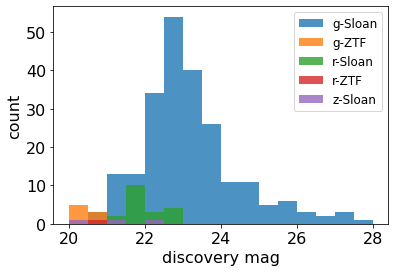

In [131]:
for filt in np.unique(filters):
    plt.hist(mag[filters==filt], bins=np.linspace(20,28,17), alpha=0.8, label=filt)

if mag_cut is not None:
    plt.axvline(mag_cut, color='k', ls='--')
plt.legend(fontsize=12)
plt.xlabel('discovery mag')
plt.ylabel('count')

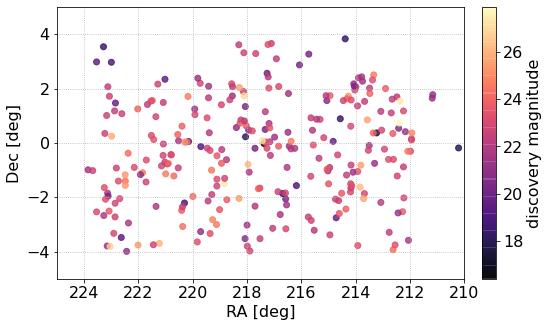

In [132]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

if mag_cut is not None:
    select = mag<mag_cut
else:
    select = np.ones(len(coords), dtype=bool)

sc = ax.scatter(coords.ra[select], coords.dec[select], c=mag[select], cmap='magma', alpha=0.8)
cb = fig.colorbar(sc, fraction=0.046, pad=0.04)
cb.set_label('discovery magnitude')
ax.set(aspect='equal',
       xlim=(225, 210), xlabel='RA [deg]',
       ylim=(-5,5), ylabel='Dec [deg]')
ax.grid(ls=':')

## Write ToO Ledger

In [146]:
def write_too_ledger(filename, too_table, checker, overwrite=False, verbose=False):
    """Write ToO ledger in the ECSV format specified by Adam Meyers.
    These can be passed to fiberassign for secondary targeting.
    
    Parameters
    ----------
    filename : str
        Output filename of the ledger (can be an absolute path).
    too_table : pandas.DataFrame
        Table of ToO data, using DECam format.
    checker : str
        Initials of individual(s) who have verified the ToO list.
    overwrite : bool
        If True, overwrite the output file.
    verbose : bool
        If True, 
    """
    mode = 'w' if overwrite else 'a'
    if verbose:
        mode = mode + '+'
    
    with open(filename, mode) as outf:
        if overwrite:
            outf.write("""# %ECSV 0.9
# ---
# datatype:
# - {name: RA, unit: deg, datatype: float64}
# - {name: DEC, unit: deg, datatype: float64}
# - {name: PMRA, unit: mas / yr, datatype: float32}
# - {name: PMDEC, unit: mas / yr, datatype: float32}
# - {name: REF_EPOCH, unit: yr, datatype: float32}
# - {name: CHECKER, datatype: string}
# - {name: TOO_TYPE, datatype: string}
# - {name: TOO_PRIO, datatype: string}
# - {name: OCLAYER, datatype: string}
# - {name: MJD_BEGIN, unit: d, datatype: float64}
# - {name: MJD_END, unit: d, datatype: float64}
# - {name: TOOID, datatype: int32}
# meta: {DEPNAM00: desitarget, DEPNAM01: desitarget-git, DEPVER00: 0.53.0.dev4635, DEPVER01: 0.53.0-24-g58c9a719, EXTNAME: TOO, RELEASE: 9999}
# schema: astropy-2.0
RA DEC PMRA PMDEC REF_EPOCH CHECKER TOO_TYPE TOO_PRIO OCLAYER MJD_BEGIN MJD_END TOOID\n""")
            
        today = Time.now()
        datedict = {}
        reporting = []
            
        for j, row in enumerate(too_table):
            # Ledger format:
            # datatype:
            # - {name: RA, unit: deg, datatype: float64}
            # - {name: DEC, unit: deg, datatype: float64}
            # - {name: PMRA, unit: mas / yr, datatype: float32}
            # - {name: PMDEC, unit: mas / yr, datatype: float32}
            # - {name: REF_EPOCH, unit: yr, datatype: float32}
            # - {name: CHECKER, datatype: string}
            # - {name: TOO_TYPE, datatype: string}
            # - {name: OCLAYER, datatype: string}
            # - {name: MJD_BEGIN, unit: d, datatype: float64}
            # - {name: MJD_END, unit: d, datatype: float64}
            coord = SkyCoord(ra=row['RA'], dec=row['DEC'], unit=(u.hourangle, u.degree), frame='icrs')
            ra, dec = coord.ra.to('deg').value, coord.dec.to('deg').value
            t_disc = Time(row['Discovery Date (UT)'], scale='utc')

            mag  = row['Discovery Mag/Flux']
            too_type = 'FIBER'
            too_prog = 'BRIGHT' #if mag < 21 else 'DARK'
            too_prio = 'HI'
            
            # Encode the ToO ID as: YY + DOY + NNNN.
            # E.g., ToO 15 of 17 Apr 2021 will get ID 211070015.
#             ttup = t_disc.to_datetime().timetuple()
#             yydoy = 1000*(ttup.tm_year-2000) + ttup.tm_yday
            
#             if yydoy in datedict:
#                 datedict[yydoy] += 1
#             else:
#                 datedict[yydoy] = 1

#             too_id = 10000*yydoy + datedict[yydoy]

            # Encode the ToO ID as: MJD + ID + NNN.
            mjd_disc = int(t_disc.mjd) 
            reporter = row['Reporting Group/s'].split(',')[0]
            if reporter not in reporting:
                reporting.append(reporter)
            mjd_exp = 100*mjd_disc + reporting.index(reporter)
            if mjd_exp in datedict:
                datedict[mjd_exp] += 1
            else:
                datedict[mjd_exp] = 1
            too_id = 100*mjd_exp + datedict[mjd_exp]

            epoch = 2000.0

            outf.write('{:<10.6f} {:>10.6f} {:>8.6f} {:>8.6f} {:>6.1f} {} {} {} {} {:>13.8f} {:>13.8f} {}\n'.format(
                    ra, dec, 0, 0, epoch, checker, too_type, too_prio, too_prog, t_disc.mjd, today.mjd+14, too_id))
    
        if verbose:
            outf.seek(0)
            for line in outf:
                print(line.strip())

In [147]:
write_too_ledger('ToO-input.ecsv', data[select], checker='SB/AP', overwrite=True, verbose=True)

# %ECSV 0.9
# ---
# datatype:
# - {name: RA, unit: deg, datatype: float64}
# - {name: DEC, unit: deg, datatype: float64}
# - {name: PMRA, unit: mas / yr, datatype: float32}
# - {name: PMDEC, unit: mas / yr, datatype: float32}
# - {name: REF_EPOCH, unit: yr, datatype: float32}
# - {name: CHECKER, datatype: string}
# - {name: TOO_TYPE, datatype: string}
# - {name: TOO_PRIO, datatype: string}
# - {name: OCLAYER, datatype: string}
# - {name: MJD_BEGIN, unit: d, datatype: float64}
# - {name: MJD_END, unit: d, datatype: float64}
# - {name: TOOID, datatype: int32}
# meta: {DEPNAM00: desitarget, DEPNAM01: desitarget-git, DEPVER00: 0.53.0.dev4635, DEPVER01: 0.53.0-24-g58c9a719, EXTNAME: TOO, RELEASE: 9999}
# schema: astropy-2.0
RA DEC PMRA PMDEC REF_EPOCH CHECKER TOO_TYPE TOO_PRIO OCLAYER MJD_BEGIN MJD_END TOOID
214.827604   0.057511 0.000000 0.000000 2000.0 SB/AP FIBER HI BRIGHT 58886.54625000 59336.45395047 588860001
220.298158  -2.209789 0.000000 0.000000 2000.0 SB/AP FIBER HI BRIGHT 58899.5

In [148]:
data[select]

ID,Name,RA,DEC,Obj. Type,Redshift,Host Name,Host Redshift,Reporting Group/s,Discovery Data Source/s,Classifying Group/s,Associated Group/s,Disc. Internal Name,Disc. Instrument/s,Class. Instrument/s,TNS AT,Public,End Prop. Period,Discovery Mag/Flux,Discovery Filter,Discovery Date (UT),Sender,Remarks,Ext. catalog/s
int64,str11,str12,str12,str6,float64,str25,float64,str43,str43,str17,str43,str12,str83,str24,int64,int64,int64,float64,str7,str23,str18,int64,int64
53825,AT 2020caa,14:19:18.625,+00:03:27.04,--,--,WISEA J141918.52+000327.2,0.097034,"ALeRCE, ATLAS, DESIRT","ZTF, ATLAS, DESIRT",--,ATLAS; DESIRT; ZTF,ZTF20aamibse,"ATLAS1 - ACAM1, CTIO-4m - DECAM, P48 - ZTF-Cam",--,1,1,--,19.7699,r-ZTF,2020-02-07 13:06:36.000,ALeRCE,--,--
54723,AT 2020dig,14:41:11.558,-02:12:35.24,--,--,--,--,"ZTF, AMPEL",ZTF,--,ZTF,ZTF18acvjmvs,P48 - ZTF-Cam,--,1,1,--,18.93,g-ZTF,2020-02-20 12:36:44.064,ZTF_AMPEL_COMPLETE,--,--
60945,AT 2020lng,14:09:40.580,+00:32:22.06,--,--,--,--,"ZTF, ATLAS, GaiaAlerts, Pan-STARRS1","ZTF, ATLAS, GaiaAlerts, Pan-STARRS1",--,ATLAS; GaiaAlerts; Pan-STARRS1; ZTF,ZTF20abbumno,"ATLAS1 - ACAM1, Gaia - Gaia-photometric, P48 - ZTF-Cam, PS1 - GPC1",--,1,1,--,20.8038,g-ZTF,2020-05-23 07:37:37.920,ZTF_CLU_PUBLIC,--,--
61599,SN 2020mjm,14:29:29.330,-00:01:17.76,SN II,0.005134,--,--,"ZTF, Pan-STARRS1, ATLAS, GaiaAlerts, DESIRT","ZTF, Pan-STARRS1, ATLAS, GaiaAlerts, DESIRT",Global SN Project,ATLAS; DESIRT; GaiaAlerts; Pan-STARRS1; ZTF,ZTF20abeohfn,"ATLAS1 - ACAM1, CTIO-4m - DECAM, Gaia - Gaia-photometric, P48 - ZTF-Cam, PS1 - GPC1",FTN - FLOYDS-N,1,1,--,16.4047,g-ZTF,2020-06-12 04:37:29.280,ZTF_CLU_PUBLIC,--,--
72163,SN 2020abku,14:00:51.220,-00:11:08.12,SN IIn,0.081828,2MASX J14005146-0011141,0.081828,"ALeRCE, ZTF, GaiaAlerts, ATLAS, Pan-STARRS1","ZTF, GaiaAlerts, ATLAS, Pan-STARRS1",ZTF,ATLAS; GaiaAlerts; Pan-STARRS1; ZTF,ZTF20acusylb,"ATLAS1 - ACAM1, Gaia - Gaia-photometric, P48 - ZTF-Cam, PS1 - GPC1",P60 - SEDM,1,1,--,17.8899,r-ZTF,2020-12-02 13:07:34.000,ALeRCE,--,--
72651,SN 2020acdl,14:32:12.432,+00:13:25.81,SN Ia,0.035546,WISEA J143212.30+001323.2,0.035546,"ALeRCE, ZTF, ATLAS, Pan-STARRS1, DESIRT","ZTF, ATLAS, Pan-STARRS1, DESIRT",ZTF,ATLAS; DESIRT; Pan-STARRS1; ZTF,ZTF20acwfcfs,"ATLAS1 - ACAM1, CTIO-4m - DECAM, P48 - ZTF-Cam, PS1 - GPC1",P60 - SEDM,1,1,--,18.1898,r-ZTF,2020-12-09 13:20:18.001,ALeRCE,--,--
72695,AT 2020acfd,14:50:29.845,-03:28:47.44,--,--,WISEA J145029.77-032845.4,0.0426,"ALeRCE, DESIRT, Pan-STARRS1","ZTF, DESIRT, Pan-STARRS1",--,DESIRT; Pan-STARRS1; ZTF,ZTF20acwqriu,"CTIO-4m - DECAM, P48 - ZTF-Cam, PS1 - GPC1",--,1,1,--,19.4887,r-ZTF,2020-12-10 13:15:10.002,ALeRCE,--,--
73025,SN 2020acrr,14:17:32.340,+03:49:44.40,SN Ia,0.0363,--,--,"ZTF, GaiaAlerts, ATLAS, Pan-STARRS1","ZTF, GaiaAlerts, ATLAS, Pan-STARRS1",ZTF,ATLAS; GaiaAlerts; Pan-STARRS1; ZTF,ZTF20acxtewc,"ATLAS1 - ACAM1, Gaia - Gaia-photometric, P48 - ZTF-Cam, PS1 - GPC1",LT - SPRAT,1,1,--,18.33,g-ZTF,2020-12-12 12:58:29.568,ZTF_AMPEL_COMPLETE,--,--
75242,AT 2021abo,14:26:18.165,-02:03:38.46,--,--,SDSS J142618.25-020339.8,0.186,ALeRCE,ZTF,--,ZTF,ZTF21aadrqqj,P48 - ZTF-Cam,--,1,1,--,20.2798,g-ZTF,2021-01-09 13:03:35.001,ALeRCE,--,--


In [174]:
toos = None

for _ra, _dec in zip((220.8908, 221.0202, 221.1424), (-0.758, -0.7057, -0.8466)):
    yup = np.logical_and(np.abs(coords.ra.value - _ra) < 0.01, np.abs(coords.dec.value - _dec) < 0.01)
    j = np.argwhere(yup)[0,0]
    #     j = np.argwhere(np.abs(coords.ra.value - _ra) < 0.01 and np.abs(coords.dec.value - _dec) < 0.01)[0,0]

    if toos is None:
        toos = data[j]
    else:
        toos = vstack([toos, data[j]])

In [179]:
toos.write('too_tile252_20210419.csv', format='ascii.csv', overwrite=True)

In [175]:
toos

ID,Name,RA,DEC,Obj. Type,Redshift,Host Name,Host Redshift,Reporting Group/s,Discovery Data Source/s,Classifying Group/s,Associated Group/s,Disc. Internal Name,Disc. Instrument/s,Class. Instrument/s,TNS AT,Public,End Prop. Period,Discovery Mag/Flux,Discovery Filter,Discovery Date (UT),Sender,Remarks,Ext. catalog/s
int64,str11,str12,str12,str6,float64,str25,float64,str43,str43,str17,str43,str12,str83,str24,int64,int64,int64,float64,str7,str23,str18,int64,int64
81655,AT 2021jhm,14:43:33.792,-00:45:28.80,--,--,--,--,DESIRT,DESIRT,--,DESIRT,--,CTIO-4m - DECAM,--,1,1,--,24.2223,g-Sloan,2021-04-09 07:15:17.856,DESIRT_Bot,--,--
81544,AT 2021jdf,14:44:04.848,-00:42:20.52,--,--,--,--,DESIRT,DESIRT,--,DESIRT,--,CTIO-4m - DECAM,--,1,1,--,22.5902,g-Sloan,2021-03-22 07:11:34.080,DESIRT_Bot,--,--
81607,AT 2021jfq,14:44:34.176,-00:50:47.76,--,--,--,--,DESIRT,DESIRT,--,DESIRT,--,CTIO-4m - DECAM,--,1,1,--,22.7019,g-Sloan,2021-04-06 08:10:17.472,DESIRT_Bot,--,--
